In [58]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import warnings
warnings.filterwarnings("ignore")

#Dates
import calendar
import matplotlib.dates as mdates

#plot
import seaborn as sns
import matplotlib.pyplot as plt

#Model
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
        
pd.options.display.float_format = "{:,.4f}".format
years = mdates.YearLocator() 
months = mdates.MonthLocator() 
years_fmt = mdates.DateFormatter('%Y-%m') 

In [59]:
#allow import of excel tabs
!pip install xlrd

In [60]:
def basic_EDA(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    is_NaN = df. isnull()
    row_has_NaN = is_NaN. any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    count_NaN_rows = rows_with_NaN.shape
    return print("Number of Samples: %d,\nNumber of Features: %d,\nDuplicated Entries: %d,\nNull Entries: %d,\nNumber of Rows with Null Entries: %d %.1f%%" %(size[0],size[1], sum_duplicates, sum_null,count_NaN_rows[0],(count_NaN_rows[0] / df.shape[0])*100))

def summary_table(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    return summary

def percentileCalc(df,column):
    q25, q75 = np.percentile(df[column], 25), np.percentile(df[column], 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    print ('lower: %d upper: %d' % (lower,upper))
    drop_index = df[(df[column] >=upper) | (df[column] <=lower)].index
    print('Number of rows to be removed %d'% drop_index.shape[0])
    return drop_index

In [61]:
df_benefits = pd.read_excel('../input/nhstest/junior_data_scientist_test.xls', sheet_name='Benefits')
df_contracts = pd.read_excel('../input/nhstest/junior_data_scientist_test.xls', sheet_name='Contracts')
df_products = pd.read_excel('../input/nhstest/junior_data_scientist_test.xls', sheet_name='Products')
df_trusts = pd.read_excel('../input/nhstest/junior_data_scientist_test.xls', sheet_name='Trusts')

# 1. Initial EDA and Data Cleansing

In here we present the main characteristics of each table of the provided Dataset.

In [62]:
print("**Benefits DF**")
basic_EDA(df_benefits)
print("**Contracts DF**")
basic_EDA(df_contracts)
print("**Products DF**")
basic_EDA(df_products)
print("**Trusts DF**")
basic_EDA(df_trusts)

**Benefits DF**
Number of Samples: 28890,
Number of Features: 13,
Duplicated Entries: 6,
Null Entries: 1102,
Number of Rows with Null Entries: 1102 3.8%
**Contracts DF**
Number of Samples: 839,
Number of Features: 6,
Duplicated Entries: 16,
Null Entries: 0,
Number of Rows with Null Entries: 0 0.0%
**Products DF**
Number of Samples: 584,
Number of Features: 3,
Duplicated Entries: 0,
Null Entries: 0,
Number of Rows with Null Entries: 0 0.0%
**Trusts DF**
Number of Samples: 224,
Number of Features: 3,
Duplicated Entries: 0,
Null Entries: 0,
Number of Rows with Null Entries: 0 0.0%


* Null Entries are identified in **Benefits** Dataframe
* Approximately 30 thousand samples for Benefits DF. Remaining DF's have a reduced number of samples
* Duplicated values were found in **Benefits** and **Contracts** DF

The outputs from the below codes summarised the Features, Features data types, missing and unique values:

In [63]:
print("**Benefits DF**")
summary_table(df_benefits)

**Benefits DF**


,Name,dtypes,Missing,Uniques
0,YearMonth,int64,0,12
1,Contract Type,object,0,3
2,Contract BGRP,object,0,8
3,Product Code,object,0,584
4,Px Pack Size,int64,0,27
5,Trust Code,object,0,186
6,Contract Price,float64,0,459
7,Baseline Price,float64,1102,4985
8,Purchase Price,float64,0,2195
9,Pruchase Qty,float64,0,1183


In [64]:
print("**Contracts DF**")
summary_table(df_contracts)

**Contracts DF**


,Name,dtypes,Missing,Uniques
0,Contract Code,object,0,6
1,BuyingGroupCode,object,0,8
2,Product Code,object,0,584
3,TenderType,object,0,3
4,Contract Start Date,datetime64[ns],0,5
5,Contract End DateIncl,datetime64[ns],0,7


In [65]:
print("**Products DF**")
summary_table(df_products)

**Products DF**


,Name,dtypes,Missing,Uniques
0,Px Molecule,object,0,238
1,Product Code,object,0,584
2,PxPackSize,int64,0,27


In [66]:
print("**Trusts DF**")
summary_table(df_trusts)

**Trusts DF**


,Name,dtypes,Missing,Uniques
0,Trust Code,object,0,224
1,SHA Code,object,0,11
2,SHA Name,object,0,11


From the above outputs and preliminary EDA, the following tasks were identified:
* Remove Duplicates
* Transform Dates into Datetime to facilitate handling
* Create Year, Month, Day Columns for Data Analysis
* New Features can be created: Contract Duration and Discount
* Replace NaN from Baseline Price with calculated value from Baseline Value / Purchase Quantity
* Replace "-0.0" and small values from Benefit value to 0, i.e. any value within 0.5 and -0.5 will be replaced with zero

# 1.1 Data Cleanse, New Features and Final Dataset

The data cleanse task is quite simple. Here we duplicated the original dataframes to avoid modification of original data.

As data cleanse, at this point is performed:
* Create copies and drop Duplicates from Contracts and Benefits table
* In Benefits Table, **Baseline Price** contains *NaN* values. They are replaced with calculated value "*Baseline Value / Purchase Quantity*"
* Organise YearMonth feature as datetime and extract new features

In [67]:
#Drop Duplicates
df_contracts_cl = df_contracts.copy()
df_contracts_cl = df_contracts_cl.drop_duplicates()
df_benefits_cl = df_benefits.copy()
df_benefits_cl = df_benefits_cl.drop_duplicates()

#Clean NaN values from Baseline Price - Only Baseline Price column shows this issue
df_benefits_cl['Baseline Price'].fillna(df_benefits_cl['Baseline Value'] / df_benefits_cl['Pruchase Qty'], inplace=True)

#Extract Year/Month columns In Benefit table
df_benefits_cl['YearMonth'] = pd.to_datetime(df_benefits_cl['YearMonth'], format='%Y%m')

df_benefits_cl['BenefitMonth'] = df_benefits_cl['YearMonth'].dt.month.apply(lambda x : calendar.month_name[x])
df_benefits_cl['BenefitYear'] = df_benefits_cl['YearMonth'].dt.year

#Replace small and -0 values from benefit table with 0
benefit_condition = (df_benefits_cl['Benefit']<0.5) & (df_benefits_cl['Benefit']>-0.5)
column_name = "Benefit"
new_value = 0

df_benefits_cl.loc[benefit_condition, column_name] = new_value

#Extracting Start/End Month/Year from Contract Table
df_contracts_cl['ContractStartY'] = df_contracts_cl['Contract Start Date'].dt.year
df_contracts_cl['ContractStartM'] = df_contracts_cl['Contract Start Date'].dt.month.apply(lambda x : calendar.month_name[x])
df_contracts_cl['ContractEndY'] = df_contracts_cl['Contract End DateIncl'].dt.year
df_contracts_cl['ContractEndM'] = df_contracts_cl['Contract End DateIncl'].dt.month.apply(lambda x : calendar.month_name[x])

#Creating new features
df_contracts_cl['ContractDuration'] = df_contracts_cl['Contract End DateIncl'] - df_contracts_cl['Contract Start Date']
df_contracts_cl['ContractDuration'] = (df_contracts_cl['ContractDuration'] / np.timedelta64(1, 'D')).astype(int)/365
df_benefits_cl['Discount'] = 1-(df_benefits_cl['Purchase Value'] / df_benefits_cl['Baseline Value'] )

After this initial data cleanse, we now merge all the tables into one Dataframe to facilitate Data Analysis:

In [68]:
df = pd.merge(df_benefits_cl, df_contracts_cl,  how='inner', left_on=["Product Code","Contract Type","Contract BGRP"], right_on=["Product Code","TenderType","BuyingGroupCode"], suffixes=('', '_y'))
df.drop(["TenderType","BuyingGroupCode"], axis=1,inplace = True)
df = pd.merge(df, df_products,  how='inner', left_on=["Product Code","Px Pack Size"], right_on=["Product Code","PxPackSize"], suffixes=('', '_y'))
df_final= pd.merge(df, df_trusts,  how='inner', left_on=["Trust Code"], right_on=["Trust Code"], suffixes=('', '_y'))

Here is a summary of the final Dataframe:

In [69]:
print("**Complete DF**")
basic_EDA(df_final)
summary_table(df_final)

**Complete DF**
Number of Samples: 28884,
Number of Features: 28,
Duplicated Entries: 0,
Null Entries: 0,
Number of Rows with Null Entries: 0 0.0%


,Name,dtypes,Missing,Uniques
0,YearMonth,datetime64[ns],0,12
1,Contract Type,object,0,3
2,Contract BGRP,object,0,8
3,Product Code,object,0,584
4,Px Pack Size,int64,0,27
5,Trust Code,object,0,186
6,Contract Price,float64,0,459
7,Baseline Price,float64,0,5737
8,Purchase Price,float64,0,2195
9,Pruchase Qty,float64,0,1183


In [70]:
df_final.rename(columns={"Pruchase Qty": "Purchase Qty"},inplace = True)

# 1.2 Data Summary

In this section, we understand the basic relationship between the features and how they are distributed within the dataset. A separated DF is created with the main categorical features **'Contract Type','Contract Code','Contract BGRP','SHA Name','Product Code'** for further analysis:

In [71]:
info_subgroups = df_final.loc[:,['Contract Type','Contract Code','Contract BGRP','SHA Name','Product Code']]

data_subgroups_contracts = pd.DataFrame(info_subgroups.groupby(['Contract Type','Contract BGRP','Contract Code','SHA Name']).size().to_frame('Count'))
data_subgroups_contracts.iloc[:,:-2]

Empty DataFrame
Columns: []
Index: [(G, 7NAT, ContractA, East Midlands SHA), (G, 7NAT, ContractA, East of England SHA), (G, 7NAT, ContractA, London SHA), (G, 7NAT, ContractA, North East SHA), (G, 7NAT, ContractA, North West SHA), (G, 7NAT, ContractA, South Central SHA), (G, 7NAT, ContractA, South East Coast SHA), (G, 7NAT, ContractA, South West SHA), (G, 7NAT, ContractA, West Midlands SHA), (G, 7NAT, ContractA, Yorkshire&Humber SHA), (G, DCE, ContractB, East Midlands SHA), (G, DCE, ContractB, West Midlands SHA), (G, DCE, ContractC, East Midlands SHA), (G, DCE, ContractC, West Midlands SHA), (G, DLN, ContractC, East of England SHA), (G, DLN, ContractC, London SHA), (G, DLN, ContractD, East of England SHA), (G, DLN, ContractD, London SHA), (G, DLS, ContractC, London SHA), (G, DLS, ContractC, South East Coast SHA), (G, DLS, ContractD, London SHA), (G, DLS, ContractD, South East Coast SHA), (G, DNE, ContractC, North East SHA), (G, DNE, ContractC, Yorkshire&Humber SHA), (G, DNE, ContractD, North East SHA), (G, DNE, ContractD, Yorkshire&Humber SHA), (G, DNW, ContractC, North West SHA), (G, DNW, ContractD, North West SHA), (G, DSW, ContractB, South Central SHA), (G, DSW, ContractB, South West SHA), (G, DSW, ContractB, Unknown), (G, DSW, ContractC, South Central SHA), (G, DSW, ContractC, South West SHA), (I, 2SE, ContractF, London SHA), (I, 2SE, ContractF, South East Coast SHA), (P, 2SE, ContractE, South East Coast SHA)]

* There are three main Contract Types. **G** handles most contract codes, higher variety of buying group codes and SHA locations
* Contract **I** and **P** are responsible for the same product **2SE**. Both supplying to South East Coast. Contract F supplies 2SE to London
* Contract A is the only contract that handles only one type buying group codes - 7NAT - and supplies to all locations. This BGRP is also responsible for one Product Code
* Contract C handles most BGRP. It shares some of the same BGRP that are also contained in Contract D and B
* There is a link between Product and Location. For example, DLS is always linked to London and South East Coast. One excpetion would be contract E that supplies 2SE but only to South East Coast

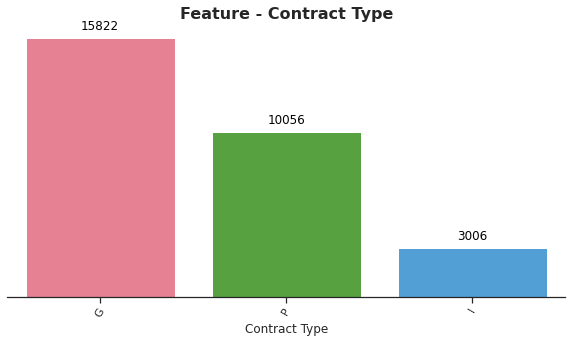

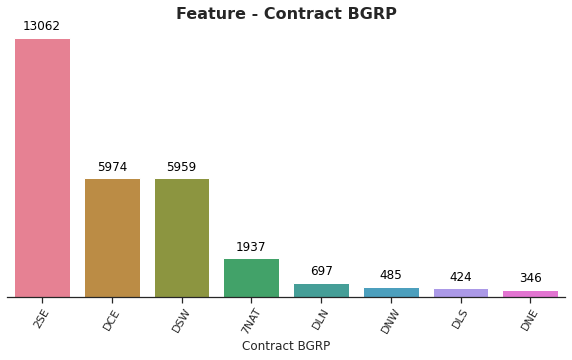

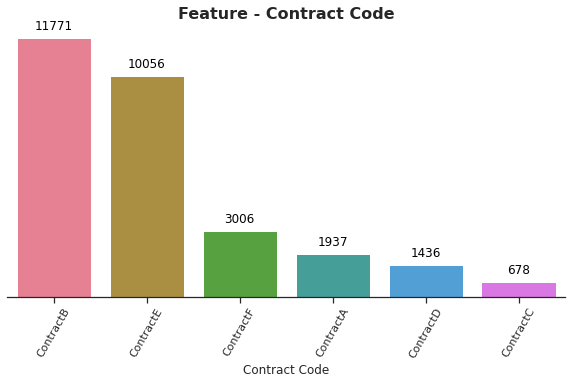

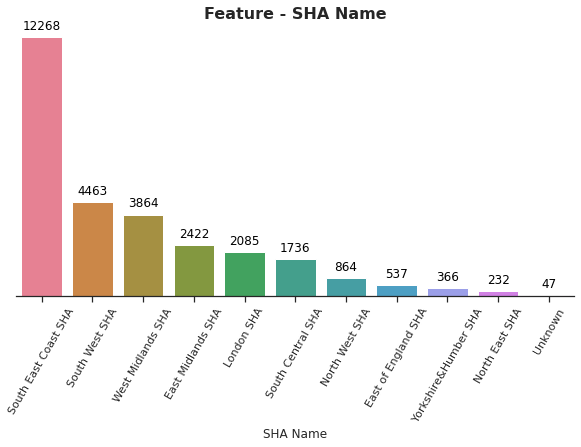

In [72]:
df_benefits_objcols = ['Contract Type',
 'Contract BGRP',
 'Contract Code',
 'SHA Name']

for i in df_benefits_objcols:
    plt.figure(figsize=(10,5))
    ax = sns.countplot(x = df_final[i], palette = 'husl', order = df_final[i].value_counts().index)
    for p in ax.patches:
            ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
            ha='center', va='bottom', color='black', xytext=(0, 5),rotation = 'horizontal',textcoords='offset points')
    #ax.set_xlabel(i)
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False)      
    plt.xticks(rotation=60)
    sns.despine(top=True, right=True, left=True, bottom=False)
    plt.title('Feature - '+ i, fontsize = 16,weight = 'bold');

* Contract Type G is more than 50% of the samples, with Contract Type P 35% and the remaining with Contract Type I
* Even though contract code I and P have a smaller participation compared to Contract Type G, they handle the largest BGRP 2SE. DCE, DSW and 7NAT follows
* Regarding Contract Codes, majority of samples belong to Contract Code B - accounting for 75% of all samples from Contract Type G
* For SHA, majority of samples belong to South East Coast as they are related to the larger BGRP 2SE
* Yorkshire and Humber, North East and Unknown are the least common values for SHA

Next, let's analyse the maximum and minimum values for the main numerical features:

In [73]:
df_final_EDA = df_final.loc[:,['Baseline Price','Purchase Price','Contract Price','Purchase Qty','Purchase Value','Baseline Value','Benefit','Contract Code']]
df_final_EDA.describe() 

,Baseline Price,Purchase Price,Contract Price,Purchase Qty,Purchase Value,Baseline Value,Benefit
count,"28,884.0000","28,884.0000","28,884.0000","28,884.0000","28,884.0000","28,884.0000","28,884.0000"
mean,36.8963,38.4816,33.3624,181.7288,"1,489.6217","1,716.4454",226.8212
std,92.9655,119.0828,88.6463,706.3959,"4,212.6253","4,900.2942","1,584.4120"
min,0.0999,0.0400,0.1000,0.0800,0.1043,0.2000,"-54,887.3498"
25%,2.4084,2.3400,2.2500,6.0000,46.9943,48.3987,-3.5201
50%,6.8681,6.3500,5.9900,20.0000,171.9911,179.9279,1.0213
75%,29.8300,27.6100,29.4500,80.1000,829.7977,864.5978,46.4520
max,"1,631.5300","10,210.0000","1,394.9600","17,400.0000","122,992.4943","110,420.4609","75,615.7100"


The maximum values for Benefit, Purchase Value and Purchase Price seem a bit off. Visualise the entire row of these samples might help understand what is behind these extreme values.

In [74]:
minmax_list = ['Purchase Value','Purchase Price','Benefit']
for i in minmax_list:
    print('\nMax '+ i) 
    print(df_final_EDA.loc[df_final_EDA[i].idxmax(),['Baseline Price','Purchase Price','Contract Price','Purchase Qty','Purchase Value','Baseline Value','Benefit','Contract Code']])


Max Purchase Value
Baseline Price          437.0
Purchase Price         534.75
Contract Price         534.75
Purchase Qty            230.0
Purchase Value   122,992.4943
Baseline Value      100,510.0
Benefit          -22,482.4943
Contract Code       ContractE
Name: 21002, dtype: object

Max Purchase Price
Baseline Price        28.13
Purchase Price     10,210.0
Contract Price         25.6
Purchase Qty            3.0
Purchase Value     30,630.0
Baseline Value        84.39
Benefit          -30,545.61
Contract Code     ContractB
Name: 10720, dtype: object

Max Benefit
Baseline Price      1,122.0
Purchase Price        56.99
Contract Price        25.95
Purchase Qty           71.0
Purchase Value     4,046.29
Baseline Value     79,662.0
Benefit           75,615.71
Contract Code     ContractB
Name: 6022, dtype: object


* **Max Purchase Price** report shows that there is a chance of wrong inputs in the data. The Purchase Price is excessively above the Baseline Price and Contract Price. It has affected the Benefit calculation severely
* **Max Benefit** achieved with Contract B, where Baseline Price is 20X the Contract and Purchase Price achieved

In [75]:
for i in minmax_list:
    print('\nMin '+ i) 
    print(df_final_EDA.loc[df_final_EDA[i].idxmin(),['Baseline Price','Purchase Price','Contract Price','Purchase Qty','Purchase Value','Baseline Value','Benefit','Contract Code']])


Min Purchase Value
Baseline Price         2.13
Purchase Price          0.1
Contract Price          0.1
Purchase Qty            1.0
Purchase Value       0.1043
Baseline Value         2.13
Benefit              2.0257
Contract Code     ContractE
Name: 24185, dtype: object

Min Purchase Price
Baseline Price       6.9014
Purchase Price         0.04
Contract Price         7.35
Purchase Qty          139.0
Purchase Value         6.25
Baseline Value     959.2946
Benefit            953.0446
Contract Code     ContractB
Name: 3951, dtype: object

Min Benefit
Baseline Price           59.5
Purchase Price           32.0
Contract Price           32.0
Purchase Qty            210.7
Purchase Value       67,424.0
Baseline Value    12,536.6502
Benefit          -54,887.3498
Contract Code       ContractB
Name: 19801, dtype: object


* **Min Purchase** Price shows an expressive discount, where final Baseline Values is more than 100X the higher than final Purchase Value
* **Min Benefit** occurred due to error in calculating Purchase Value

One indication of wrong values is an extreme difference between Baseline and Purchase Prices. Scatter Plots can help understand such situations:

<Figure size 1440x1440 with 0 Axes>

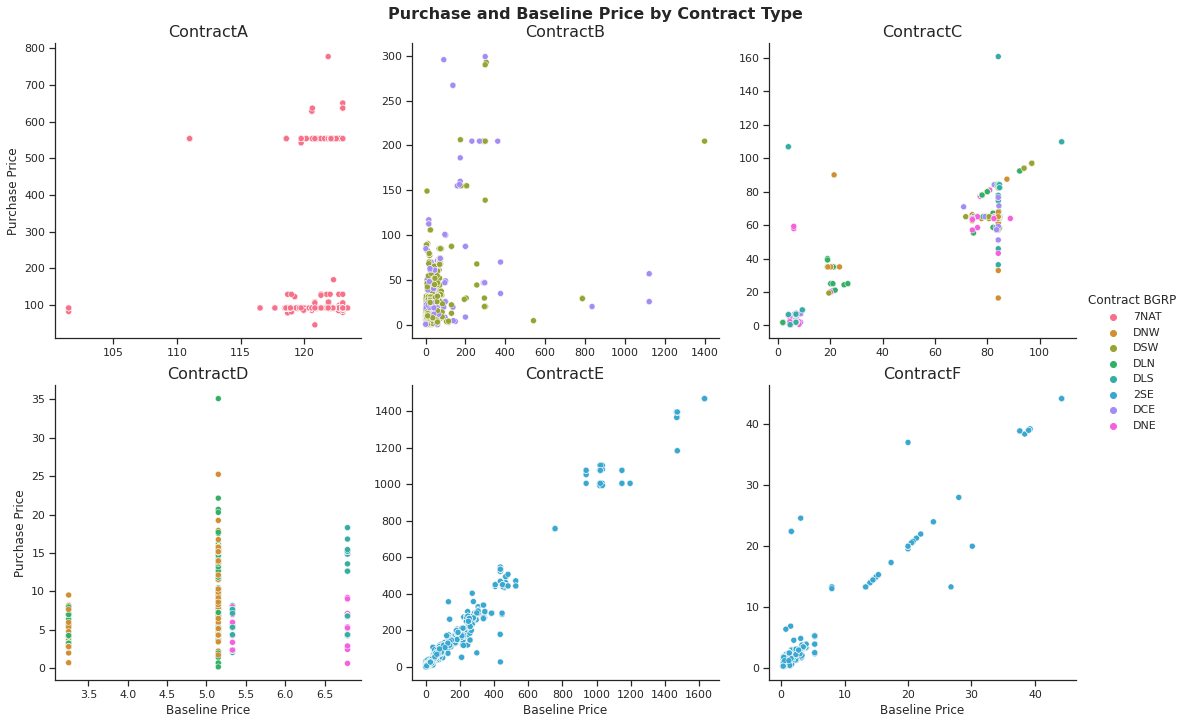

In [76]:
contract_list = ['ContractA','ContractB','ContractC','ContractD','ContractE','ContractF']

contractB_outlier = df_final[(df_final['Purchase Price']>10000)&(df_final['Contract Code']=='ContractB')].index
df_scatter_plot = df_final.copy()
df_scatter_plot.drop(contractB_outlier,inplace = True)

plt.figure(figsize=(20,20));
g = sns.relplot(
    data=df_scatter_plot, x='Baseline Price', y='Purchase Price',
    col='Contract Code', hue='Contract BGRP',
    kind="scatter",aspect=1,facet_kws={'sharey': False, 'sharex': False},palette = 'husl',
    col_order = contract_list,col_wrap =3
)

g.set_titles(col_template="{col_name}", row_template="{row_name}", size = 16);
g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Purchase and Baseline Price by Contract Type',fontsize=16, weight = 'bold');

* Contract A is responsible only for buying group and product, but does not show an expected linear relantioship between Purchase and Baseline. Two clusters are being shown in the data
* Contract B, when ignoring the outlier, Baseline Price is usually higher than Purchase Price
* Contract C, handles more buying group codes than A and B. Overall, presents linear pattern, the vertical line is acceptable as it shows that the baseline price was constant but the purchase price was below baseline
* Contract D, shows a Purchase Price that varies significantly for the same Baseline Price
* Contract E and F share the same buying group code. However, their value ranges vary due to different products
* Overall, the Contract Codes seem to separate the data well

<Figure size 1440x1440 with 0 Axes>

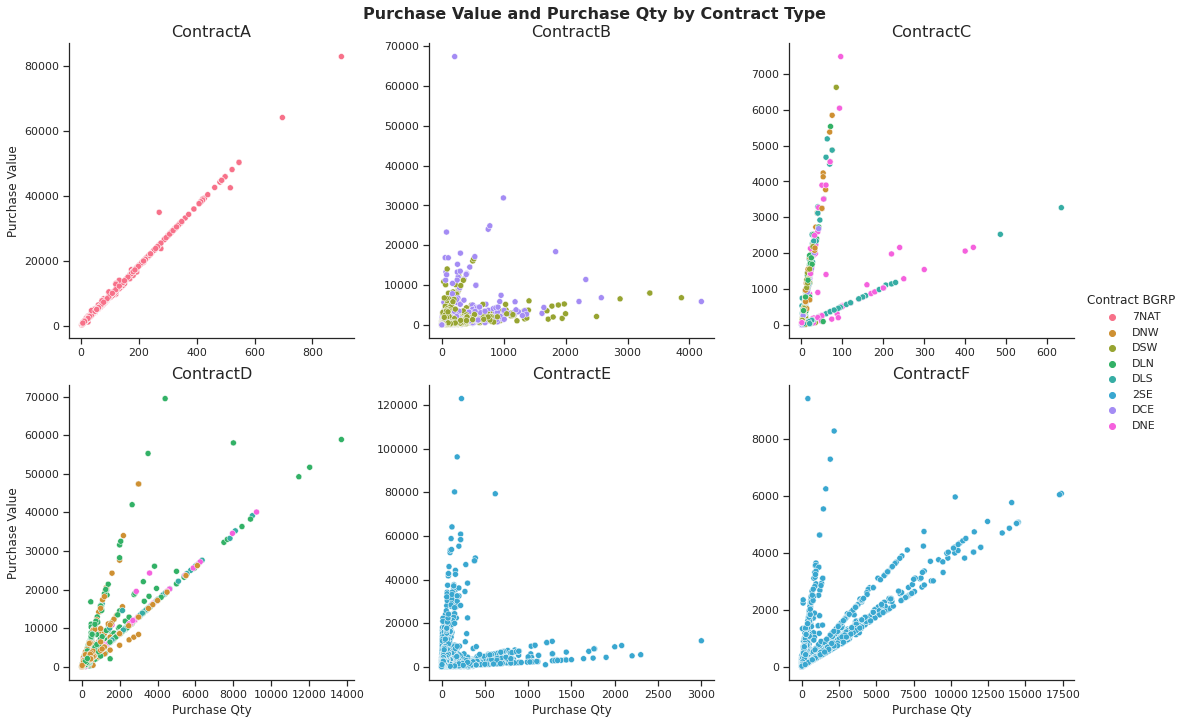

In [77]:
plt.figure(figsize=(20,20));
g = sns.relplot(
    data=df_scatter_plot, x='Purchase Qty', y='Purchase Value',
    col='Contract Code', hue='Contract BGRP',
    kind="scatter",aspect=1,facet_kws={'sharey': False, 'sharex': False},palette = 'husl',
    col_order = contract_list,col_wrap =3
)

g.set_titles(col_template="{col_name}", row_template="{row_name}", size = 16);
g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Purchase Value and Purchase Qty by Contract Type',fontsize=16, weight = 'bold');

<Figure size 1440x1440 with 0 Axes>

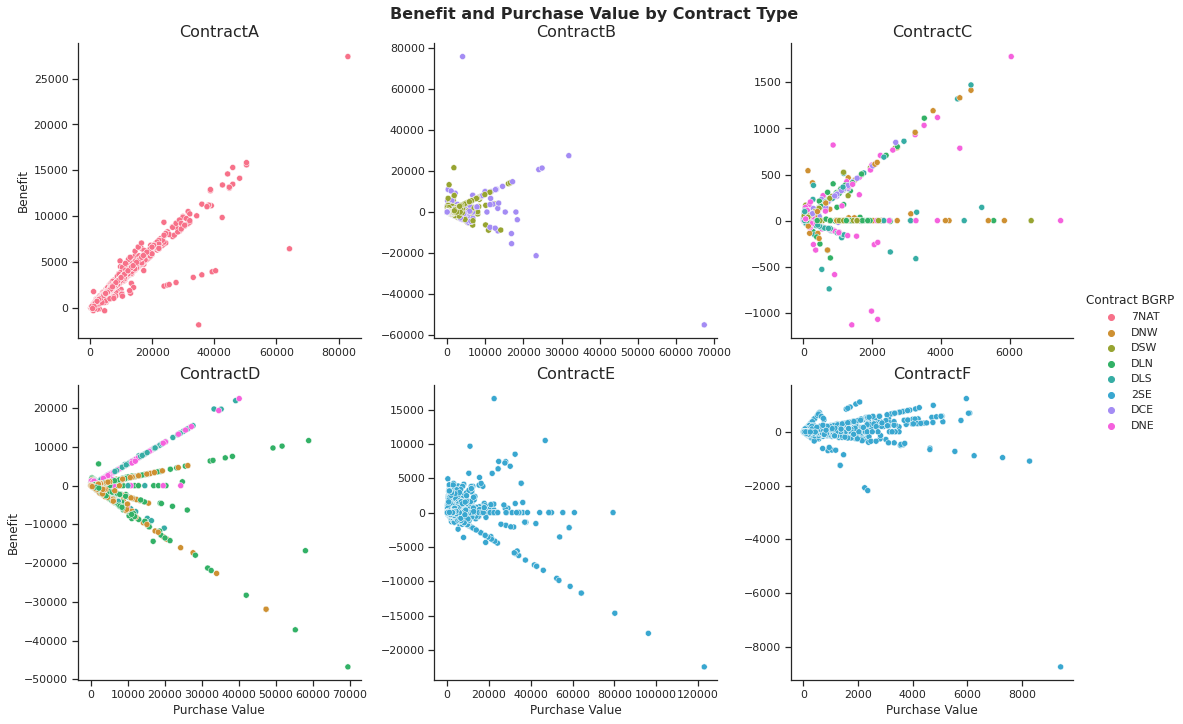

In [78]:
plt.figure(figsize=(20,20));
g = sns.relplot(
    data=df_scatter_plot, x='Purchase Value', y='Benefit',
    col='Contract Code', hue='Contract BGRP',
    kind="scatter",aspect=1,facet_kws={'sharey': False, 'sharex': False},palette = 'husl',
    col_order = contract_list,col_wrap =3
)

g.set_titles(col_template="{col_name}", row_template="{row_name}", size = 16);
g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Benefit and Purchase Value by Contract Type',fontsize=16, weight = 'bold');

* Purchase Value and Qty have proved some of the assumptions
* Higher Purchase values are linked to lower benefits, speacially for contracts B, D and E
* No Negative Benefits for Contract A
* Quantity is linearly related to Purchase Value

# 1.3 Basic Checks

So far, we have seen that the data contains several outliers and different patterns according to the Contract Type. In this section we perform basic sanity checks to understand how reliable is our data:
* Check for rows where Purchase Price and Value are the same, but quantity is not 1
* Check for rows where Purchase Price is higher than Purchase Value, and quantity is 1 or higher
* Check for rows where Quantity is 1, and Purchase Price and Value do not match
* Check provided Equations are valid

In [79]:
df_final_EDA[(df_final_EDA['Purchase Price']==df_final_EDA['Purchase Value']) & (df_final_EDA['Purchase Qty']>1)].head(5)

,Baseline Price,Purchase Price,Contract Price,Purchase Qty,Purchase Value,Baseline Value,Benefit,Contract Code
1728,6.2575,13.3000,6.1600,2.0000,13.3000,12.5150,-0.7850,ContractB
1807,120.8042,553.5000,92.2500,6.0000,553.5000,724.8252,171.3252,ContractA
1816,120.8042,553.5000,92.2500,6.0000,553.5000,724.8252,171.3252,ContractA
1817,120.8042,553.5000,92.2500,6.0000,553.5000,724.8252,171.3252,ContractA
1822,120.8042,553.5000,92.2500,6.0000,553.5000,724.8252,171.3252,ContractA


* The above rows are not following the rule **Purchase Value = Purchase Price * Purchase Qty**. One option would be to use the Contract Price to correct these values. However, the contract values does not always match the result of the division of  **Purchase Value** by **Quantity** (see row 27315, and 3250)
* Issue is present only in Contracts A and B. Approximately 20 Instances

In [80]:
df_final_EDA[(df_final_EDA['Purchase Price'].round(2)!=df_final_EDA['Purchase Value'].round(2)) & (df_final_EDA['Purchase Qty']==1)].head(5)

,Baseline Price,Purchase Price,Contract Price,Purchase Qty,Purchase Value,Baseline Value,Benefit,Contract Code
553,25.0321,1.1400,31.5000,1.0000,28.3830,25.0321,-3.3509,ContractB
554,25.0321,1.1600,31.5000,1.0000,29.0000,25.0321,-3.9679,ContractB
844,36.0000,1.8000,18.0000,1.0000,18.0000,36.0000,18.0000,ContractB
1643,59.5000,15.1700,32.0000,1.0000,151.7000,59.5000,-92.2000,ContractB
1737,24.5000,3.2400,19.8500,1.0000,32.4000,24.5000,-7.9000,ContractB


* Filtering by Qty = 1, some instances the Purchase Price and Purchase Value do not match
* The Purchase Value is usually higher than Purchase Price for this scenario
* As consequence, Benefit is impacted as the Baseline Price and Value are lower than Purchase Value
* Occurs for Contracts B and E, for 67 samples

In [81]:
df_final_EDA[(df_final_EDA['Purchase Price'].round(2)>df_final_EDA['Purchase Value'].round(2))].head(5)

,Baseline Price,Purchase Price,Contract Price,Purchase Qty,Purchase Value,Baseline Value,Benefit,Contract Code


* There are no instances where the Purchase Price is higher than Purchase Value

# 1.3.1 Benefits, Purchase Value and Benefit Value Review

Here we check if the provided information of how the data and target values is obtained is reliable. Basically we will check:
* Purchase Value = Purchase Price x Purchase Qty
* Baseline Value = Baseline Price x Purchase Qty
* Benefit = Purchase Value - Baseline Value

The following new features are created:
* **Benefit_Recalc**: Baseline Value - Purchase Value 
    * Idea is to ensure that Benefit has been calculated correctly from these two original features from the dataset
* **Benefit_Recalc_Bool**: Makes a Boolean check if **Benefit_Recalc** matches the original  **Benefit** feature. Here decimal points of difference are not considered, i.e. values are rounded to 0   

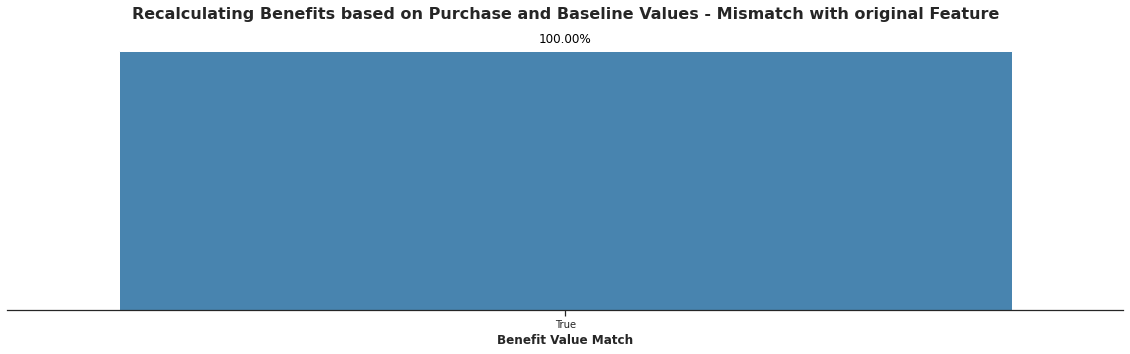

In [82]:
df_final_EDA['Benefit_Recalc'] =  df_final_EDA['Baseline Value'] - df_final_EDA['Purchase Value']
df_final_EDA['Benefit_Recalc_Bool'] = df_final_EDA['Benefit_Recalc'].round(0) == df_final_EDA['Benefit'].round(0)

check_BenValueRev = df_final_EDA.groupby(['Benefit_Recalc_Bool']).size().reset_index(name='counts')

plt.figure(figsize=(20,5))
sns.set(style="ticks", font_scale = 1)
ax = sns.barplot(data = check_BenValueRev,y='counts', x = 'Benefit_Recalc_Bool',
                  palette="Blues_d")

sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0,fontsize = 10)
ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False) 
ax.set_xlabel('Benefit Value Match',fontsize = 12,weight = 'bold')
plt.title('Recalculating Benefits based on Purchase and Baseline Values - Mismatch with original Feature', fontsize = 16,weight = 'bold',pad=20);

for p in ax.patches: 
    ax.annotate("%.2f%%" % (100*float(p.get_height()/df_final_EDA.shape[0])), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
         ha='center', va='bottom', color='black', xytext=(0, 6),rotation = 'horizontal',
         textcoords='offset points')

The target Benefit seems to be according to the definition, when using the provided Purchase Value and Baseline Value features.

However, from previous analysis, it was possible to spot mismatches between Purchase Price and Purchase Value. The test below recalculates the Purchase Value and Baseline Value features, based on the given Purchase and Baseline Price. The output is then used to recalculate the Benefit. 

In [83]:
df_final_EDA['Purchase Value_calc'] = df_final_EDA['Purchase Price'] * df_final_EDA['Purchase Qty']
df_final_EDA['Purchase Value_Bool'] = df_final_EDA['Purchase Value_calc'].round(0) == df_final_EDA['Purchase Value'].round(0)

df_final_EDA['Baseline Value_calc'] = df_final_EDA['Baseline Price'] * df_final_EDA['Purchase Qty']
df_final_EDA['Baseline Value_Bool'] = df_final_EDA['Baseline Value_calc'].round(0) == df_final_EDA['Baseline Value'].round(0)

df_final_EDA['Benefit_calc'] =  df_final_EDA['Baseline Value_calc'] - df_final_EDA['Purchase Value_calc']
df_final_EDA['Benefit Value_Bool'] = df_final_EDA['Benefit_calc'].round(0) == df_final_EDA['Benefit'].round(0)

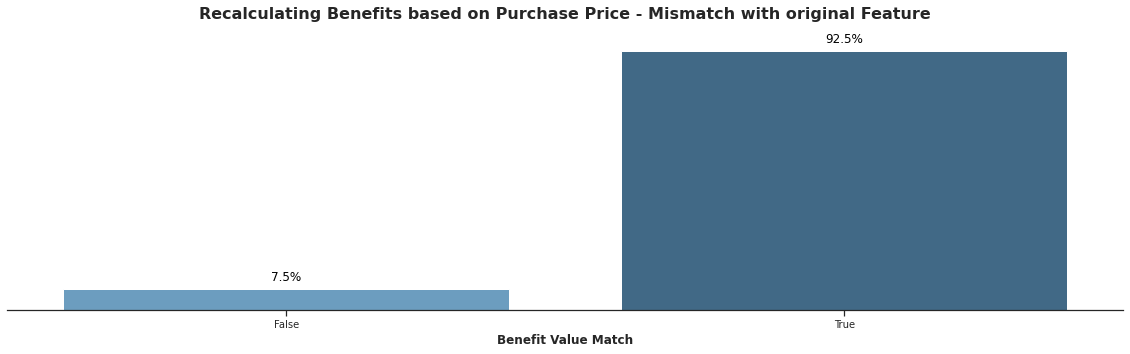

In [84]:
check_BenValue = df_final_EDA.groupby(['Benefit Value_Bool']).size().reset_index(name='counts')

plt.figure(figsize=(20,5))
sns.set(style="ticks", font_scale = 1)
ax = sns.barplot(data = check_BenValue,y='counts', x = 'Benefit Value_Bool',
                  palette="Blues_d")

sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0,fontsize = 10)
ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False) 
ax.set_xlabel('Benefit Value Match',fontsize = 12,weight = 'bold')
plt.title('Recalculating Benefits based on Purchase Price - Mismatch with original Feature', fontsize = 16,weight = 'bold',pad=20);

for p in ax.patches: 
    ax.annotate("%.1f%%" % (100*float(p.get_height()/df_final_EDA.shape[0])), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
         ha='center', va='bottom', color='black', xytext=(0, 6),rotation = 'horizontal',
         textcoords='offset points')

* Using the Purchase Price and Baseline Price to recalculate all the fields, the mismatch increases
* Increasing the number of decimal places to be considered, the mismatch reaches about 30% of samples

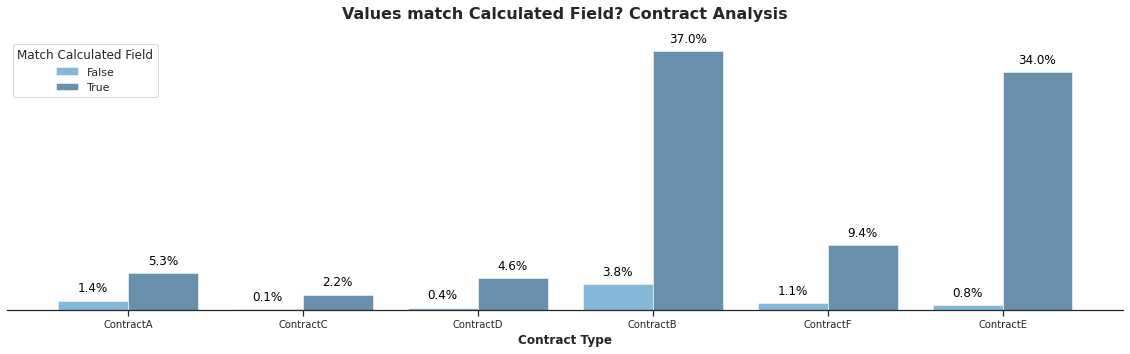

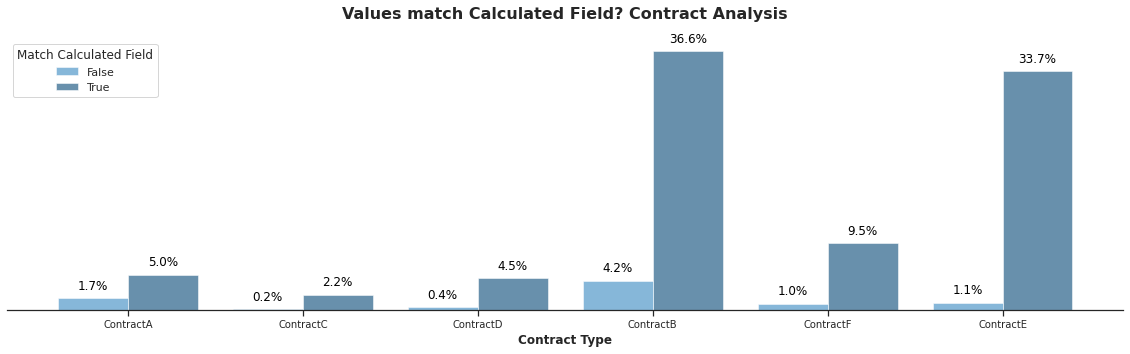

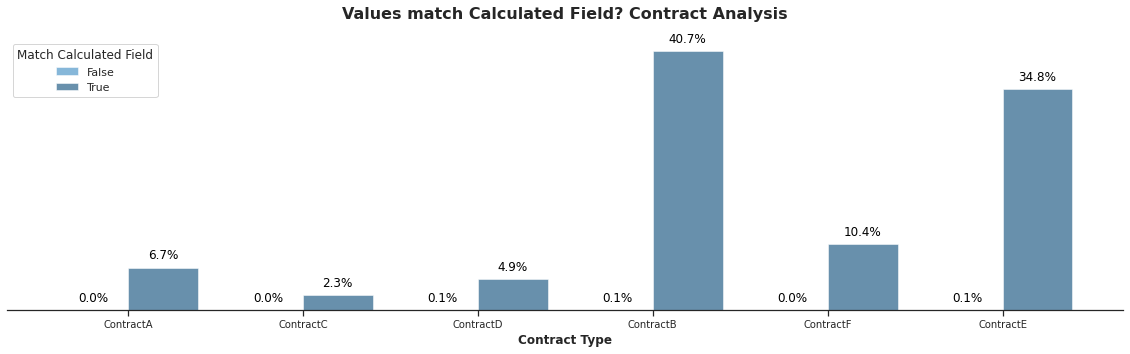

In [85]:
for i in ["Benefit Value_Bool",'Purchase Value_Bool',"Baseline Value_Bool"]:
        plt.figure(figsize=(20,5))
        sns.set(style="ticks", font_scale = 1)
        ax = sns.histplot(df_final_EDA,x='Contract Code', hue=i,multiple="dodge",
                          palette="Blues_d",shrink=.8,linewidth= .5)
        leg = ax.axes.get_legend()#add legend title
        leg.set_title('Match Calculated Field')#add legend title
        sns.despine(top=True, right=True, left=True, bottom=False)
        plt.xticks(rotation=0,fontsize = 10)
        ax.set(yticklabels=[])
        ax.axes.get_yaxis().set_visible(False) 
        ax.set_xlabel('Contract Type',fontsize = 12,weight = 'bold')
        plt.title('Values match Calculated Field? Contract Analysis', fontsize = 16,weight = 'bold',pad=20);

        for p in ax.patches: 
            ax.annotate("%.1f%%" % (100*float(p.get_height()/df_final_EDA.shape[0])), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
                 ha='center', va='bottom', color='black', xytext=(0, 6),rotation = 'horizontal',
                 textcoords='offset points')

* For 7% of samples it was identified that the rule **Baseline Value - Purchase Value** does not apply. Issues are probably due to input errors in Purchase Price field
* Baseline Value has minor mismatch between calculated and values from the original feature. It indicates that the issue is coming from Purchase Price field
* Note how Purchase Value and Benefits have a similar trend on the number of instances that do not match the original value

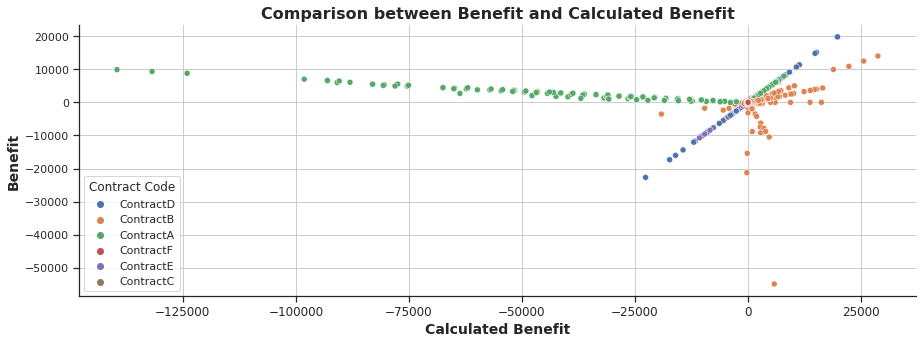

In [86]:
df_mismatch = df_final_EDA[df_final_EDA['Benefit Value_Bool']==False]

plt.figure(figsize=(15,5))
sns.set(style="ticks", font_scale = 1)
ax = sns.scatterplot(data=df_mismatch, y='Benefit', x='Benefit_calc', hue = 'Contract Code')#, s = 18)

sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Calculated Benefit',fontsize = 14,weight = 'bold')
ax.set_ylabel('Benefit',fontsize = 14,weight = 'bold')
plt.title('Comparison between Benefit and Calculated Benefit',fontsize = 16,weight = 'bold');
plt.grid() 

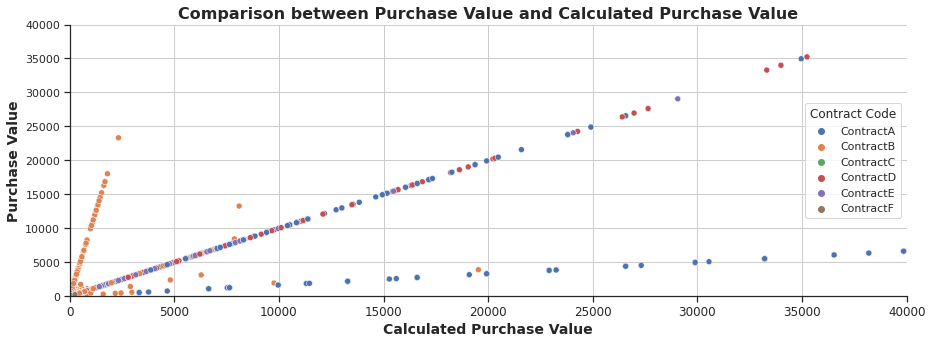

In [87]:
plt.figure(figsize=(15,5))
sns.set(style="ticks", font_scale = 1)
ax = sns.scatterplot(data=df_mismatch, y='Purchase Value', x='Purchase Value_calc', hue = 'Contract Code',
                    hue_order = contract_list)

sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Calculated Purchase Value',fontsize = 14,weight = 'bold')
ax.set_ylim(0,40000)
ax.set_xlim(0,40000)
ax.set_ylabel('Purchase Value',fontsize = 14,weight = 'bold')
plt.title('Comparison between Purchase Value and Calculated Purchase Value',fontsize = 16,weight = 'bold');
plt.grid() 

* For contract B, the pattern seems to be that the Benefit in the spreadsheet is much higher than the calculated Benefit
* Contract A shows two patterns. One where probably the Purchase Price was inputed wrongly and too high. As such, when multiplying by the Quantity it went exceendigly high
* Contract D and A share a pattern where the Benefit is also higher than the Calculated Benefit

In [88]:
mismatch_participation = df_mismatch.groupby(['Contract Code','Benefit Value_Bool' ]).size().reset_index(name='counts')
mismatch_participation.loc[:,['Contract Code','counts']]

,Contract Code,counts
0,ContractA,394
1,ContractB,1084
2,ContractC,37
3,ContractD,111
4,ContractE,222
5,ContractF,304


Contracts A and B are more prone to errors in Benefit Fields, probably due to Purchase Price input errors.

# 1.4 Contract A Outliers



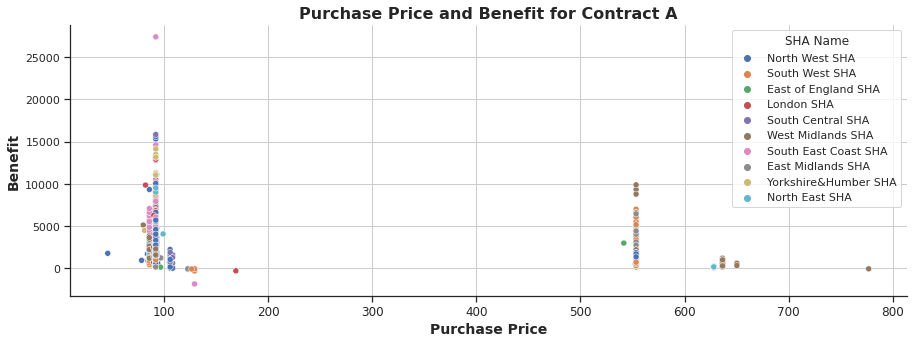

In [89]:
df_contractA = df_final.loc[:,['Baseline Price','Purchase Price','Contract Price','Purchase Qty',
                               'Baseline Value','Purchase Value','Benefit','Contract Code',
                               'YearMonth','SHA Name']]
df_contractA = df_contractA[df_contractA['Contract Code']=='ContractA']

plt.figure(figsize=(15,5))
sns.set(style="ticks", font_scale = 1)
ax = sns.scatterplot(data=df_contractA, x='Purchase Price', y='Benefit', hue = 'SHA Name')

sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Purchase Price',fontsize = 14,weight = 'bold')
ax.set_ylabel('Benefit',fontsize = 14,weight = 'bold')
plt.title('Purchase Price and Benefit for Contract A',fontsize = 16,weight = 'bold');
plt.grid() 

In [90]:
outliers_A = df_contractA[df_contractA['Purchase Price']>500].copy()
outliers_A.head(5)

,Baseline Price,Purchase Price,Contract Price,Purchase Qty,Baseline Value,Purchase Value,Benefit,Contract Code,YearMonth,SHA Name
888,123.0000,553.5000,92.2500,72.0000,"8,856.0000","6,642.0000","2,214.0000",ContractA,2009-05-01,West Midlands SHA
889,123.0000,553.5000,92.2500,48.0000,"5,904.0000","4,428.0000","1,476.0000",ContractA,2010-01-01,West Midlands SHA
890,123.0000,553.5000,92.2500,24.0000,"2,952.0000","2,214.0000",738.0000,ContractA,2009-04-01,West Midlands SHA
891,123.0000,553.5000,92.2500,48.0000,"5,904.0000","4,428.0000","1,476.0000",ContractA,2009-11-01,West Midlands SHA
892,123.0000,553.5000,92.2500,48.0000,"5,904.0000","4,428.0000","1,476.0000",ContractA,2009-07-01,West Midlands SHA


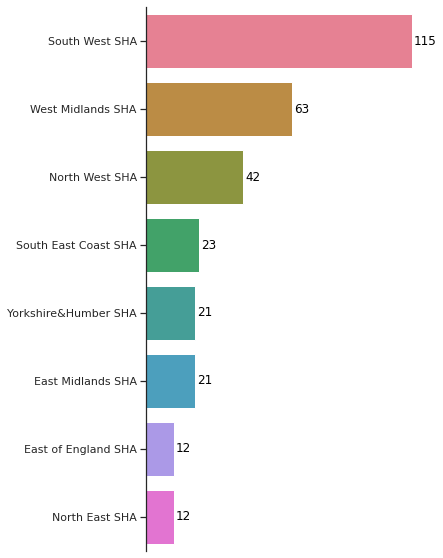

In [91]:
plt.figure(figsize=(5,10))
ax = sns.countplot(y = outliers_A['SHA Name'], palette = 'husl', order = outliers_A['SHA Name'].value_counts().index)
for p in ax.patches:
        width = int(p.get_width())
        ax.annotate("%d" % p.get_width(), (width, p.get_y() + p.get_height()/ 2),
        ha='left', va='center', color='black', xytext=(2, 0),rotation = 'horizontal',textcoords='offset points')
#ax.set_xlabel(i)
sns.despine(top=True, right=True, left=False, bottom=True)
ax.set(ylabel=None)
ax.set(xticklabels=[])
ax.axes.get_xaxis().set_visible(False) 

In [92]:
outlier_index = df_contractA[df_contractA['Purchase Price']>500].index
df_contractA['outlier'] = False
df_contractA.loc[outlier_index,'outlier'] = True

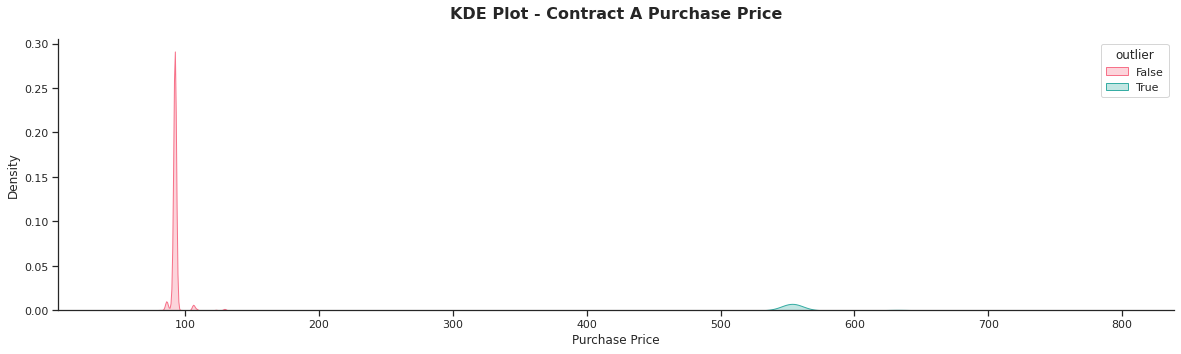

In [93]:
plt.figure(figsize=(20,5))
ax = sns.kdeplot(data = df_contractA, x = 'Purchase Price', linewidth=1,alpha=.3, fill = True,palette = 'husl', hue = 'outlier') 
#ax.set_xlabel(i)
plt.title('KDE Plot - Contract A Purchase Price', fontsize = 16,weight = 'bold',pad=20);  
sns.despine(top=True, right=True, left=False, bottom=False)

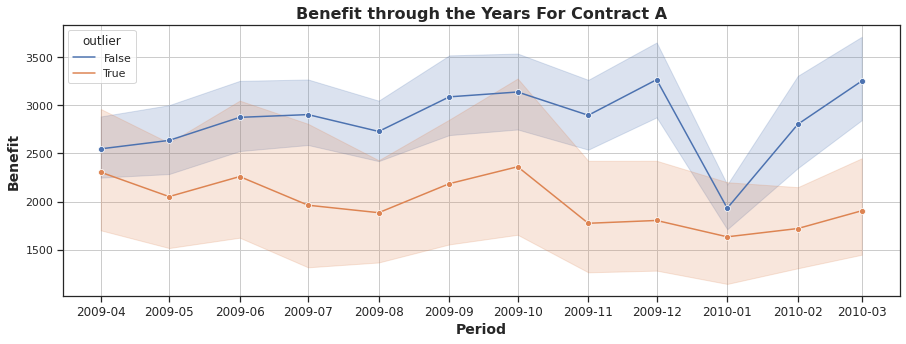

In [94]:
plt.figure(figsize=(15,5))
sns.set(style="ticks", font_scale = 1)
ax = sns.lineplot(data=df_contractA, x='YearMonth', y="Benefit",marker = 'o', hue='outlier')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Period',fontsize = 14,weight = 'bold')
ax.set_ylabel('Benefit',fontsize = 14,weight = 'bold')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Benefit through the Years For Contract A',fontsize = 16,weight = 'bold');
plt.grid()

* Not clear where the outliers are coming from
* It does not seem to be related to a specific Time Period, Contract BGRP or Product Code. The latter because Contract A only handles one type of Product Code
* It could be related to SHA Name, as 50% of outliers are coming from South West SHA

# 1.5 Removing Outliers

As a preliminary analysis, it was possible to conclude that most features are Positively Skewed. This implies that the data does not present a Gaussian Distribution, with most of the outliers being above the median value. 

Outliers are removed based on Interquartile Range. A factor of 1.5 is used to identify values that are outliers. Since the data distribution varies according to contract, the extreme values are removed based on their contract group code

In [95]:
df_preprocess = df_final.copy()
df_preprocess = df_preprocess.sort_values('YearMonth')

<Figure size 1440x1440 with 0 Axes>

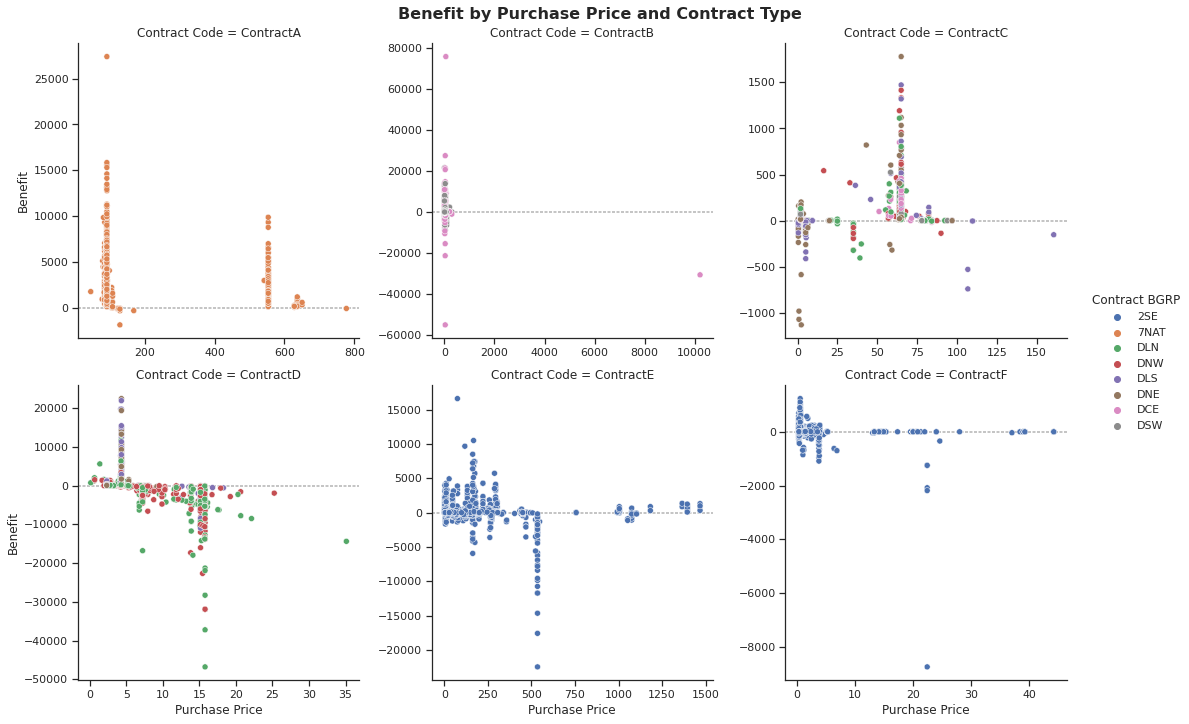

In [96]:
plt.figure(figsize=(20,20));
g = sns.relplot(
    data=df_preprocess, x='Purchase Price',y='Benefit',
    col='Contract Code', hue='Contract BGRP',
    kind="scatter",aspect=1,facet_kws={'sharey': False, 'sharex': False},
    col_order = contract_list,col_wrap = 3
)

(g.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
  .set_axis_labels("Purchase Price", "Benefit"))

g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Benefit by Purchase Price and Contract Type',fontsize=16, weight = 'bold');

In [97]:
for i in contract_list:
    df_preprocess.drop(percentileCalc(df_preprocess[df_preprocess['Contract Code']==i],'Benefit'), inplace = True)

lower: -2190 upper: 6923
Number of rows to be removed 89
lower: -57 upper: 67
Number of rows to be removed 2895
lower: -179 upper: 298
Number of rows to be removed 91
lower: -2046 upper: 2801
Number of rows to be removed 353
lower: -27 upper: 43
Number of rows to be removed 2916
lower: -55 upper: 89
Number of rows to be removed 630


<Figure size 1440x1440 with 0 Axes>

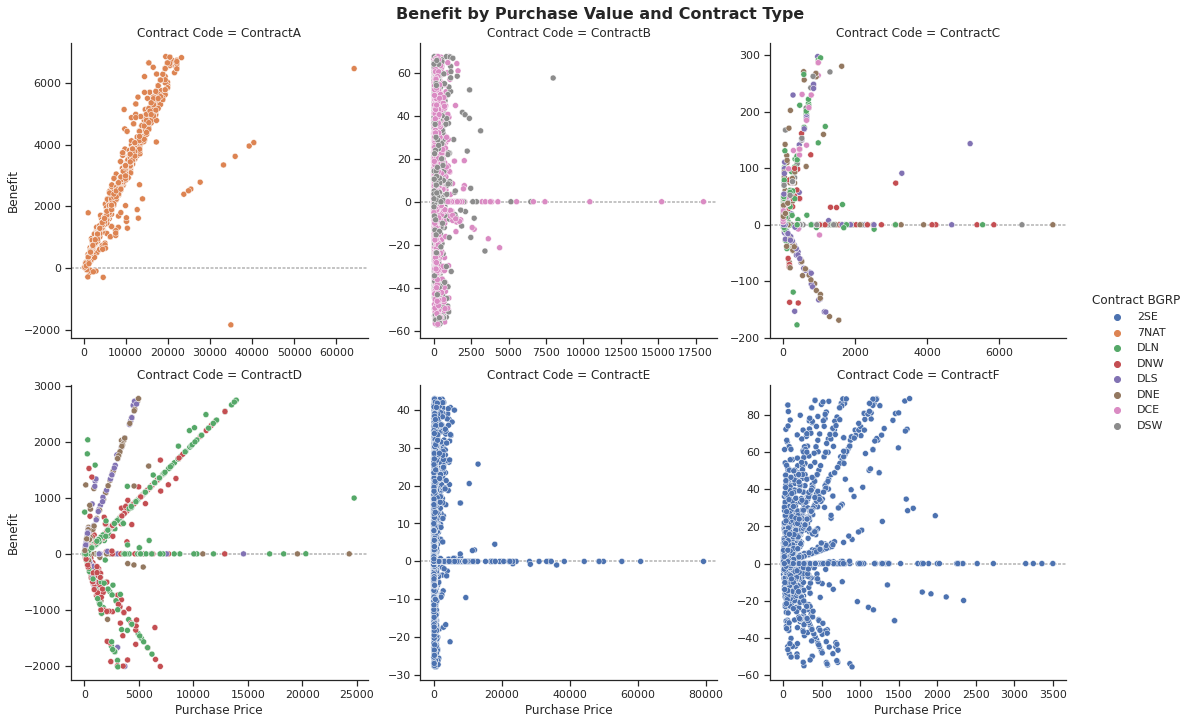

In [98]:
plt.figure(figsize=(20,20));
g = sns.relplot(
    data=df_preprocess, x='Purchase Value',y='Benefit',
    col='Contract Code', hue='Contract BGRP',
    kind="scatter",aspect=1,facet_kws={'sharey': False, 'sharex': False},
    col_order = contract_list,col_wrap = 3
)

(g.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
  .set_axis_labels("Purchase Price", "Benefit"))

g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Benefit by Purchase Value and Contract Type',fontsize=16, weight = 'bold');

Removal of outliers allows to better visualise the data and its trends

# 2. Most Beneficial Contract

Now that major outliers were removed, we can understand what contract is the most valuable.

First, let's see how the Benefit has changed along the two years available (2009 and 2010):

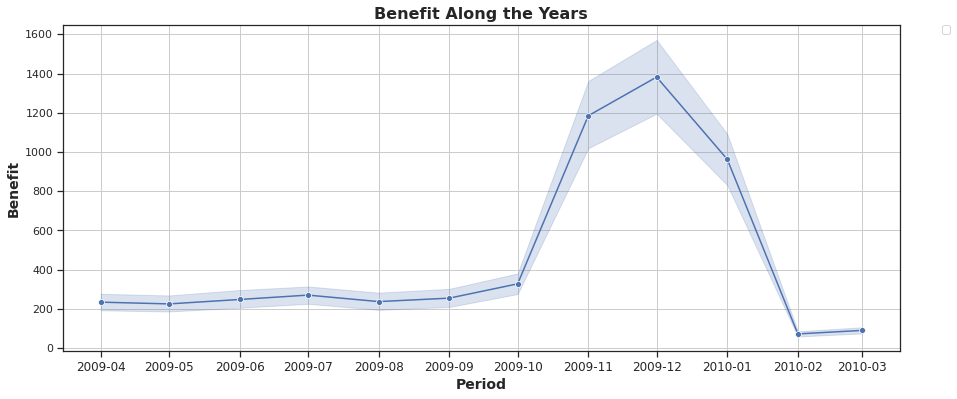

In [99]:
plt.figure(figsize=(15,6))
sns.set(style="ticks", font_scale = 1)
ax = sns.lineplot(data=df_preprocess, x='YearMonth', y="Benefit",marker = 'o')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Period',fontsize = 14,weight = 'bold')
ax.set_ylabel('Benefit',fontsize = 14,weight = 'bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Benefit Along the Years',fontsize = 16,weight = 'bold');
plt.grid()

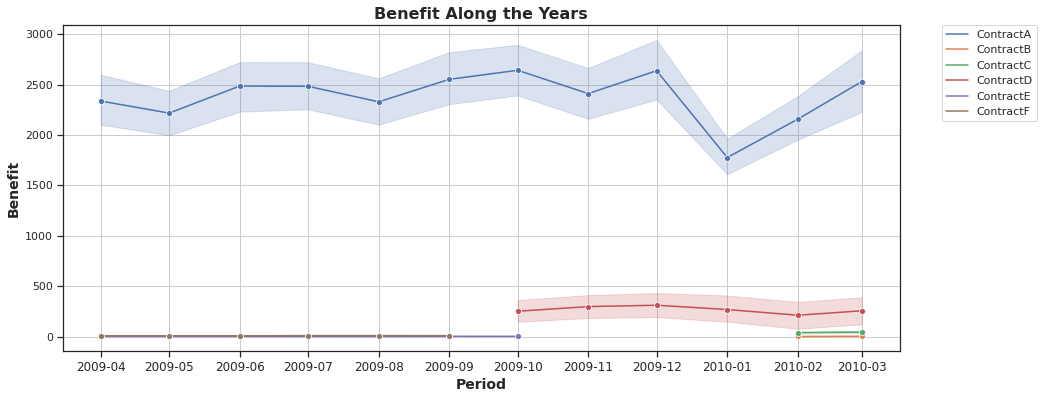

In [100]:
plt.figure(figsize=(15,6))
sns.set(style="ticks", font_scale = 1)
ax = sns.lineplot(data=df_preprocess, x='YearMonth', y="Benefit",marker = 'o',
                  hue = 'Contract Code', hue_order = contract_list)

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Period',fontsize = 14,weight = 'bold')
ax.set_ylabel('Benefit',fontsize = 14,weight = 'bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Benefit Along the Years',fontsize = 16,weight = 'bold');
plt.grid()

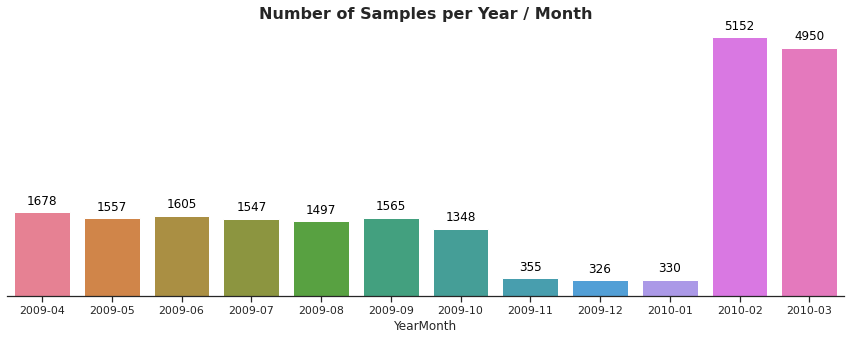

In [101]:
plt.figure(figsize=(15,5))
ax = sns.countplot(data = df_preprocess, x = 'YearMonth', palette = 'husl')#, order = df_time['YearMonth'].value_counts().index)
for p in ax.patches:
        ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(0, 5),rotation = 'horizontal',textcoords='offset points')

x_dates = df_preprocess['YearMonth'].dt.strftime('%Y-%m').sort_values().unique()
ax.set_xticklabels(labels=x_dates, ha='center')

ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False)         
sns.despine(top=True, right=True, left=True, bottom=False)

plt.title('Number of Samples per Year / Month', fontsize = 16,weight = 'bold');

* Contract A seems to be the most beneficial
* Contract D also pose a high impact on the Benefit
* Remaining contracts have a small benefit range, that is easily overtaken by Contracts A and D
* Period of less Contract samples (end of year for 2009) has higher profit

# 2.1 Contract and BGPR with More Benefits

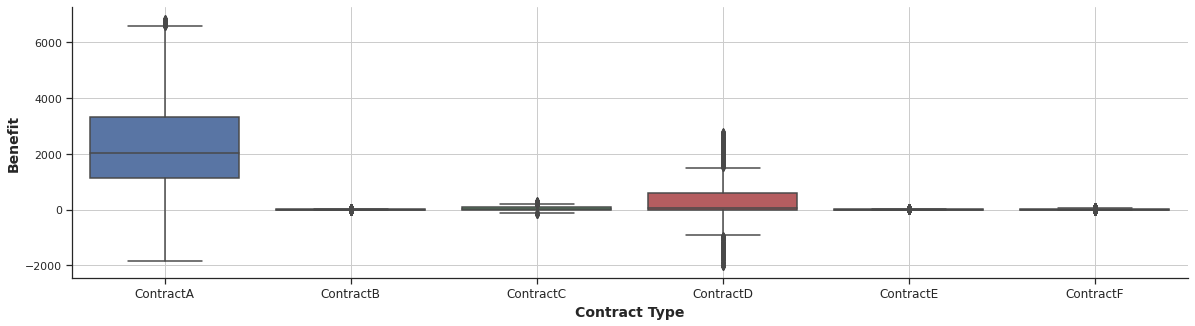

In [102]:
plt.figure(figsize=(20,5))
sns.set(style="ticks", font_scale = 1)
ax = sns.boxplot(data=df_preprocess, y='Benefit', x='Contract Code',order=['ContractA','ContractB','ContractC','ContractD','ContractE','ContractF'])
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Contract Type',fontsize = 14,weight = 'bold')
ax.set_ylabel('Benefit',fontsize = 14,weight = 'bold');
plt.grid()

* Contract A is the only contract that present median higher than 150 pounds. Even its lower bound values are higher than the median of the other contracts. Probably due to the fact that it handles only one product

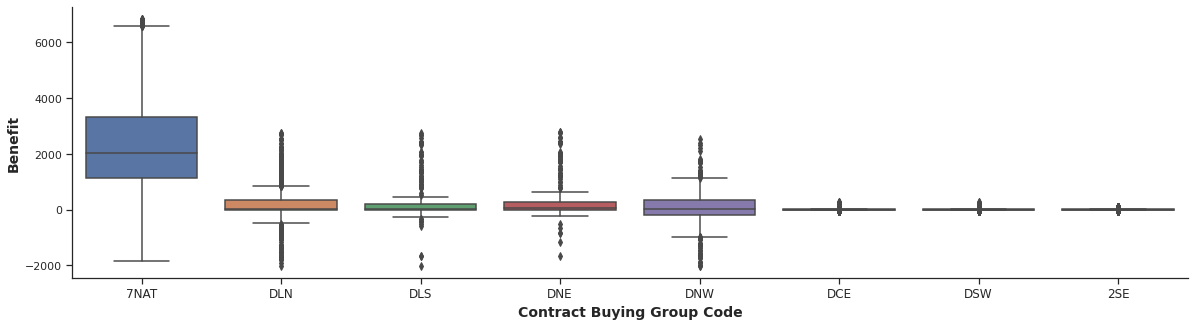

In [103]:
plt.figure(figsize=(20,5))
sns.set(style="ticks", font_scale = 1)
ax = sns.boxplot(data=df_preprocess, y='Benefit', x='Contract BGRP',order=['7NAT','DLN','DLS','DNE','DNW','DCE','DSW','2SE'])
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Contract Buying Group Code',fontsize = 14,weight = 'bold')
ax.set_ylabel('Benefit',fontsize = 14,weight = 'bold');

* In accordance to the Contract A, 7NAT product also presents a similar distribution. A higher median and lower bound than the remaining products.
* 2SE, DSW and DCE present smaller variances (narrow upper and lower bounds). However, also displays a greater number of outliers

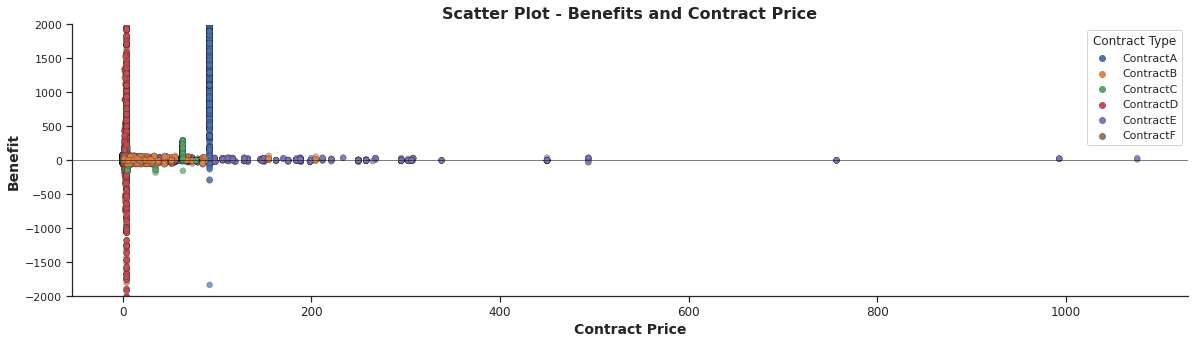

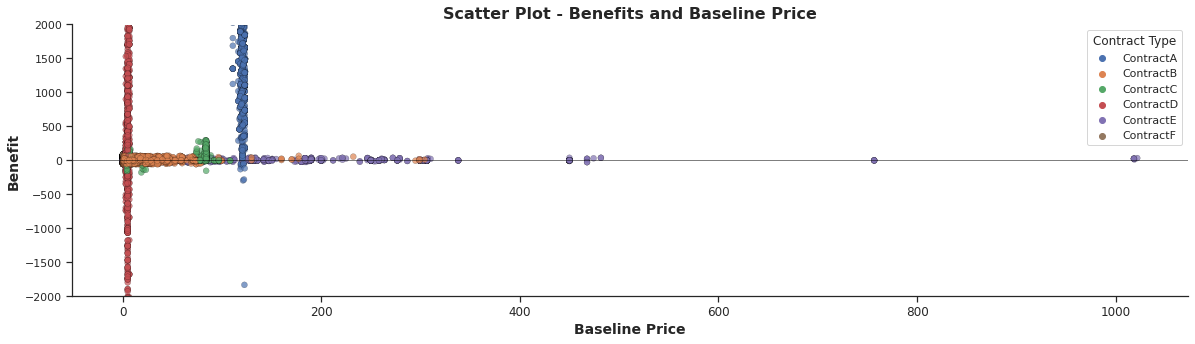

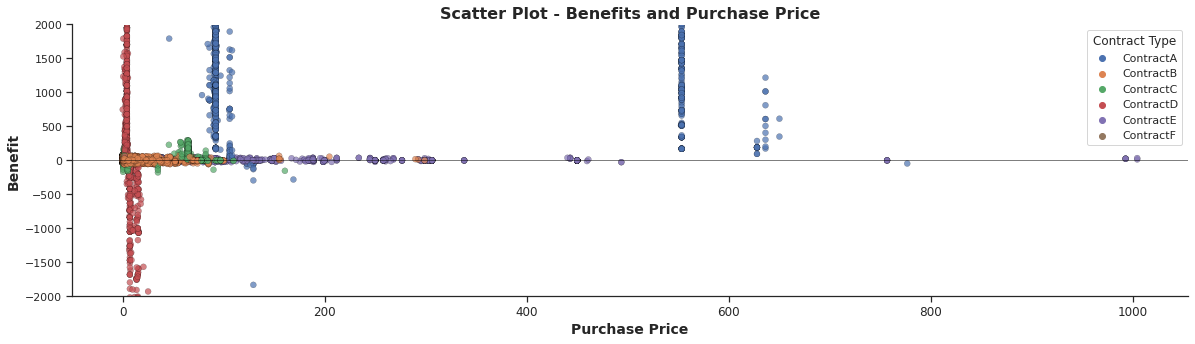

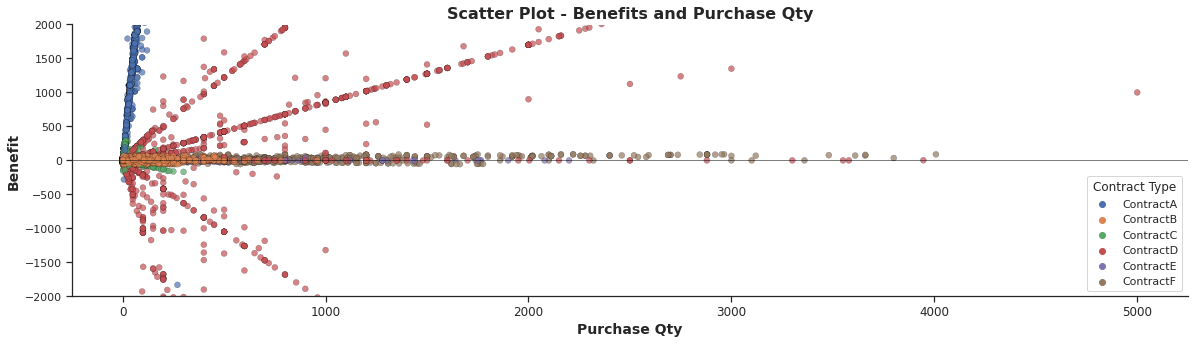

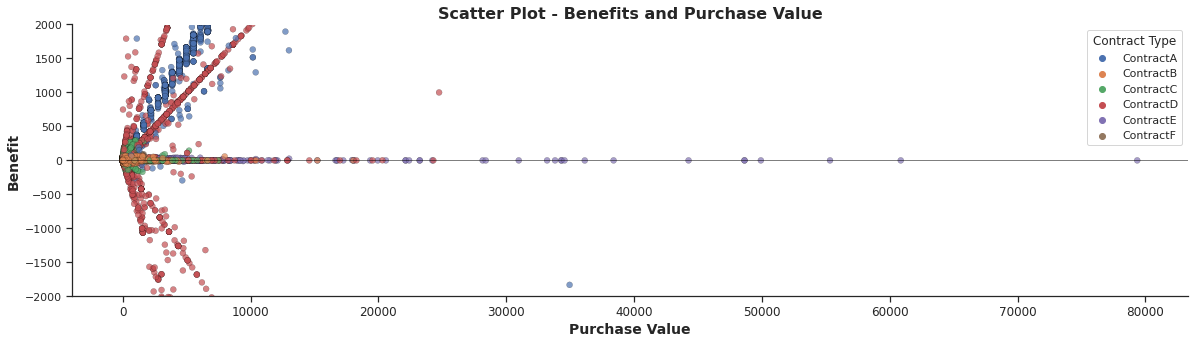

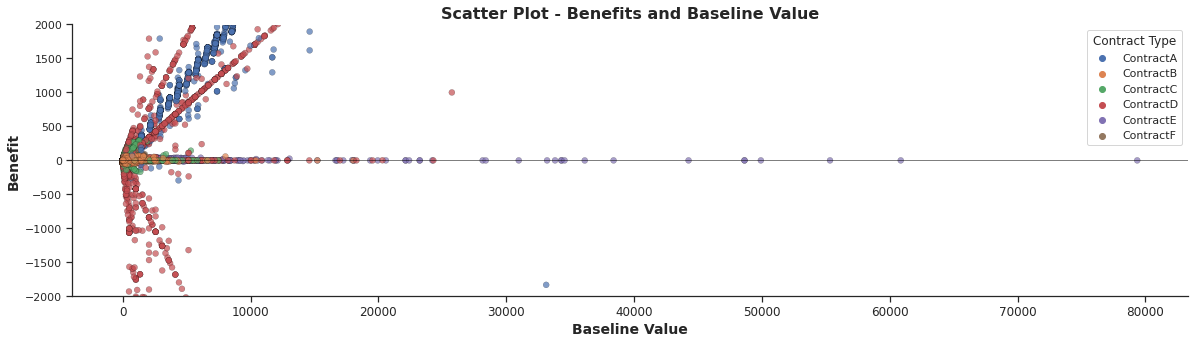

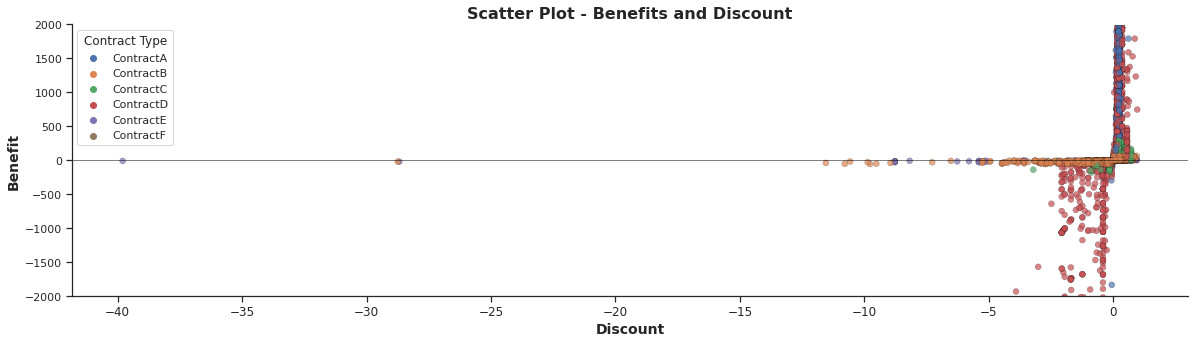

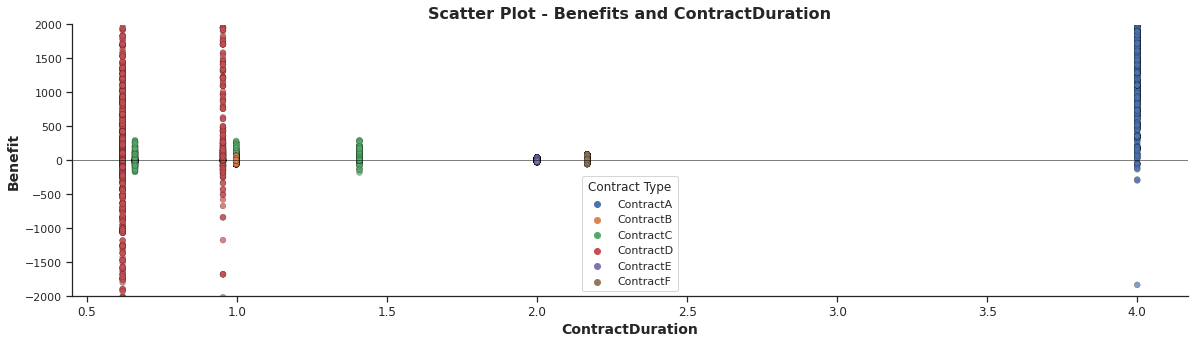

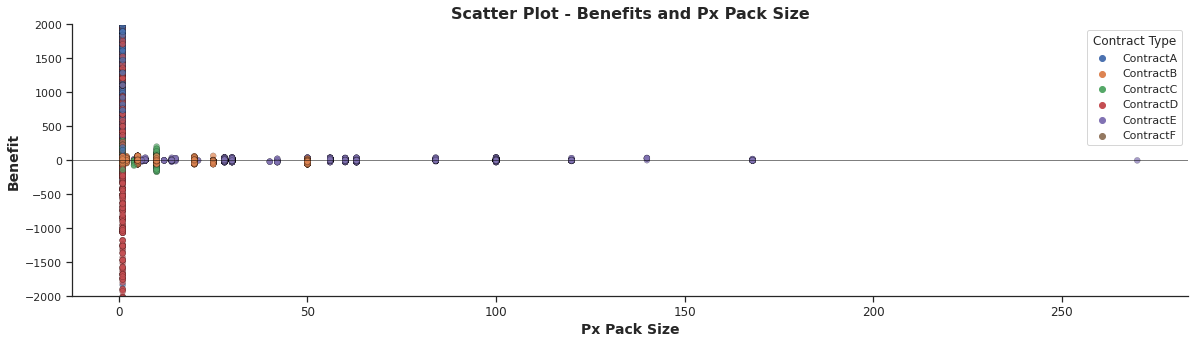

In [104]:
benefit_scatter = ['Contract Price','Baseline Price','Purchase Price','Purchase Qty','Purchase Value',
                    'Baseline Value','Discount','ContractDuration','Px Pack Size']

for i in benefit_scatter:
    plt.figure(figsize=(20,5))
    sns.set(style="ticks", font_scale = 1)
    ax = sns.scatterplot(data=df_preprocess, y='Benefit', x=df_preprocess[i], 
                         hue = 'Contract Code',hue_order = contract_list,edgecolor="black",linewidth=0.2, alpha = 0.7)
    ax.axhline(0, c = 'black', linewidth=0.5)
    leg = ax.axes.get_legend()#add legend title
    leg.set_title('Contract Type')#add legend title
    sns.despine(top=True, right=True, left=False, bottom=False)
    plt.xticks(rotation=0,fontsize = 12)
    ax.set_xlabel(i,fontsize = 14,weight = 'bold')
    ax.set_ylabel('Benefit',fontsize = 14,weight = 'bold')
    ax.set_ylim(-2000,2000)
    plt.title('Scatter Plot - Benefits and '+ i,fontsize = 16,weight = 'bold');

# 3. Forecast Contract F Benfits

Here we create a separate DF for Contract F. The process is the following:
* Create separate Contract F Dataframe
* Verify the distribution of each period
* Compute the Mean for each Period
* Define Training and Test Sets
* Apply AR, MA and ARIMA models

In [105]:
df_contractF = df_preprocess[(df_preprocess['Contract Code']=='ContractF')]

In [106]:
df_contractF[['YearMonth','Benefit']]

,YearMonth,Benefit
14102,2009-04-01,52.7450
14089,2009-04-01,6.3000
14084,2009-04-01,5.4000
6957,2009-04-01,12.0031
6953,2009-04-01,-3.0251
...,...,...
11016,2009-09-01,-54.1305
10994,2009-09-01,-3.8847
11013,2009-09-01,-29.6334
10970,2009-09-01,10.8000


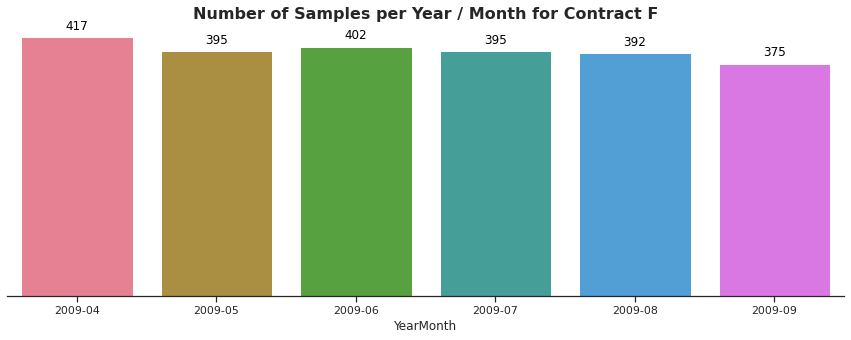

In [107]:
plt.figure(figsize=(15,5))
ax = sns.countplot(data = df_contractF, x = 'YearMonth', palette = 'husl')#, order = df_time['YearMonth'].value_counts().index)
for p in ax.patches:
        ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(0, 5),rotation = 'horizontal',textcoords='offset points')

x_dates = df_contractF['YearMonth'].dt.strftime('%Y-%m').sort_values().unique()
ax.set_xticklabels(labels=x_dates, ha='center')

ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False)         
sns.despine(top=True, right=True, left=True, bottom=False)

plt.title('Number of Samples per Year / Month for Contract F', fontsize = 16,weight = 'bold');

* Each period contributes similarly to Contract F. There is no unbalance of data in that sense

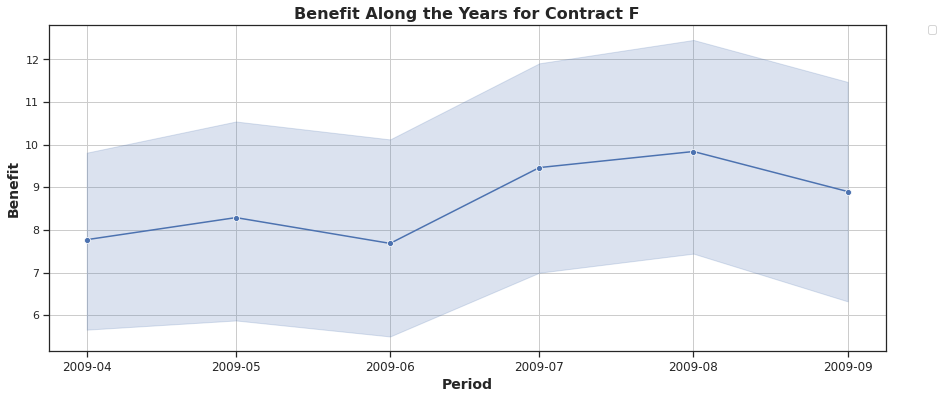

In [108]:
plt.figure(figsize=(15,6))
sns.set(style="ticks", font_scale = 1)
ax = sns.lineplot(data=df_contractF, x='YearMonth', y="Benefit",marker = 'o')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Period',fontsize = 14,weight = 'bold')
ax.set_ylabel('Benefit',fontsize = 14,weight = 'bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Benefit Along the Years for Contract F',fontsize = 16,weight = 'bold');
plt.grid()

In [109]:
#Group By Period
data = df_contractF.groupby('YearMonth')['Benefit'].mean().reset_index()
data = data.set_index('YearMonth')
data.index = pd.DatetimeIndex(data.index.values,freq=data.index.inferred_freq)
#Define Training and Test Sets
train = data.iloc[:5]
#Validation ignores the first instance or training data
val = train.iloc[1:,-1:]
test = data.iloc[5]

Challenges: 
* Small Dataset
* Not possible to create additional lag features (t-5)
* Validation or Cross Validation is compromised when using lag higher than 2
* Ideally  time series should be validated as rolling window
* ARIMA models not ideal for such small dataset



0.781551051008074 0.7455109493078176
0.7342843471794303 0.3551229253827781
0.6805110568015059 0.11020786023891205


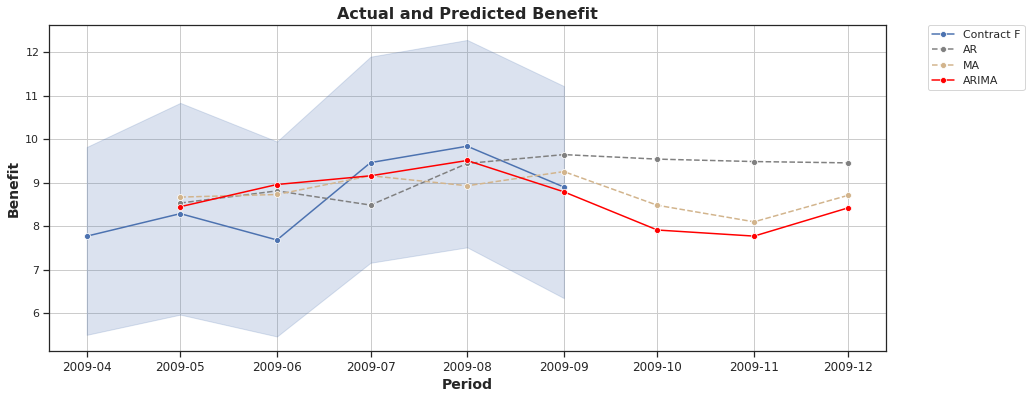

In [110]:
#Models
model_AutoRegression = AutoReg(train, lags=1,old_names=False)
model_MA = ARIMA(train, order=(0, 0, 3))
model_ARIMA = ARIMA(train, order=(2, 0, 2))

#Predictions and Fitting Models
def stats_regressions(model):
    model_fit = model.fit()
    y_pred = model_fit.predict(start=val.index.min(), end=val.index.max())

    # Test set prediction
    yhat = model_fit.predict(len(train), len(train))
    #y_forec, conf_int  = model_fit.predict(3,return_conf_int=True,alpha=0.05)
    #print(conf_int)
    y_future = model_fit.predict(len(train)+1, len(train)+3)
    preds = y_pred.append([yhat,y_future], ignore_index=False)
    RMSE_val = mean_squared_error(val, y_pred, squared=False)
    
    RMSE_test = mean_squared_error(test, yhat, squared=False)
    print(RMSE_val,RMSE_test)
    return preds,RMSE_val,RMSE_test

#results for each model
preds_AR,RMSE_val_AR,RMSE_test_AR = stats_regressions(model_AutoRegression)
preds_MA,RMSE_val_MA,RMSE_test_MA = stats_regressions(model_MA)
preds_ARIMA,RMSE_val_ARIMA,RMSE_test_ARIMA = stats_regressions(model_ARIMA)

plt.figure(figsize=(15,6))
sns.set(style="ticks", font_scale = 1)
ax = sns.lineplot(data=df_contractF, x='YearMonth', y="Benefit",marker = 'o',label='Contract F')
ax = sns.lineplot(data=preds_AR, x=preds_AR.index, y=preds_AR,marker = 'o',color = 'grey',ls='--',label='AR')
ax = sns.lineplot(data=preds_MA, x=preds_MA.index, y=preds_MA,marker = 'o',color = 'tan',ls='--',label='MA')
ax = sns.lineplot(data=preds_ARIMA, x=preds_ARIMA.index, y=preds_ARIMA,marker = 'o',color = 'red',label='ARIMA')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Period',fontsize = 14,weight = 'bold')
ax.set_ylabel('Benefit',fontsize = 14,weight = 'bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Actual and Predicted Benefit',fontsize = 16,weight = 'bold');
plt.grid()